### 9.2 GAN으로 새로운 패션 아이템 생성하기

#### 9.2.1 학습 준비

In [12]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다:", DEVICE)

# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST('./ .data',
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))
train_loader = torch.utils.data.DataLoader(
dataset = trainset,
batch_size = BATCH_SIZE,
shuffle = True)

다음 장치를 사용합니다: cpu


#### 9.2.2 생성자와 판별자 구현

In [7]:
# 생성자 (Generator)
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh())

In [8]:
# 판별자 (Discriminator), Leaky ReLU 활성화 함수를 사용
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

#### 9.2.3 GAN 학습 구현

In [9]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 교차 엔트로피 오차 함수와 생상자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [10]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'.format(epoch, EPOCHS, d_loss.item(), g_loss.item(),
                                                                                         real_score.mean().item(), fake_score.mean().item()))

이폭 [0/500] d_loss:0.0316 g_loss: 4.8547 D(x):0.99 D(G(z)):0.02
이폭 [1/500] d_loss:0.0350 g_loss: 5.9017 D(x):0.98 D(G(z)):0.01
이폭 [2/500] d_loss:0.1488 g_loss: 5.9621 D(x):0.95 D(G(z)):0.01
이폭 [3/500] d_loss:0.0323 g_loss: 5.5764 D(x):0.99 D(G(z)):0.02
이폭 [4/500] d_loss:0.2885 g_loss: 4.3164 D(x):0.96 D(G(z)):0.16
이폭 [5/500] d_loss:0.0823 g_loss: 4.8647 D(x):0.98 D(G(z)):0.04
이폭 [6/500] d_loss:0.1455 g_loss: 5.5897 D(x):0.97 D(G(z)):0.04
이폭 [7/500] d_loss:0.0920 g_loss: 5.7491 D(x):0.96 D(G(z)):0.03
이폭 [8/500] d_loss:0.0909 g_loss: 5.2170 D(x):0.96 D(G(z)):0.03
이폭 [9/500] d_loss:0.2652 g_loss: 4.8708 D(x):0.95 D(G(z)):0.08
이폭 [10/500] d_loss:0.4806 g_loss: 3.8155 D(x):0.85 D(G(z)):0.07
이폭 [11/500] d_loss:0.0956 g_loss: 4.8042 D(x):0.96 D(G(z)):0.04
이폭 [12/500] d_loss:0.3136 g_loss: 4.1125 D(x):0.93 D(G(z)):0.10
이폭 [13/500] d_loss:0.3067 g_loss: 4.1211 D(x):0.95 D(G(z)):0.15
이폭 [14/500] d_loss:0.2445 g_loss: 3.5715 D(x):0.95 D(G(z)):0.13
이폭 [15/500] d_loss:0.1903 g_loss: 3.3733 D(x):0.94

이폭 [128/500] d_loss:0.9038 g_loss: 1.3681 D(x):0.72 D(G(z)):0.36
이폭 [129/500] d_loss:1.0031 g_loss: 1.6115 D(x):0.65 D(G(z)):0.31
이폭 [130/500] d_loss:0.9412 g_loss: 1.4807 D(x):0.75 D(G(z)):0.35
이폭 [131/500] d_loss:1.0270 g_loss: 1.3831 D(x):0.72 D(G(z)):0.37
이폭 [132/500] d_loss:0.9836 g_loss: 1.8578 D(x):0.76 D(G(z)):0.36
이폭 [133/500] d_loss:0.8778 g_loss: 1.7403 D(x):0.69 D(G(z)):0.26
이폭 [134/500] d_loss:0.9478 g_loss: 1.3645 D(x):0.69 D(G(z)):0.31
이폭 [135/500] d_loss:0.9409 g_loss: 1.6461 D(x):0.68 D(G(z)):0.27
이폭 [136/500] d_loss:0.9940 g_loss: 1.6737 D(x):0.61 D(G(z)):0.26
이폭 [137/500] d_loss:1.0732 g_loss: 1.6432 D(x):0.63 D(G(z)):0.31
이폭 [138/500] d_loss:1.0560 g_loss: 1.3007 D(x):0.71 D(G(z)):0.39
이폭 [139/500] d_loss:0.7890 g_loss: 1.5859 D(x):0.72 D(G(z)):0.26
이폭 [140/500] d_loss:1.0383 g_loss: 1.5055 D(x):0.65 D(G(z)):0.33
이폭 [141/500] d_loss:1.2796 g_loss: 1.4436 D(x):0.66 D(G(z)):0.43
이폭 [142/500] d_loss:0.9152 g_loss: 1.5738 D(x):0.69 D(G(z)):0.31
이폭 [143/500] d_loss:1.151

이폭 [255/500] d_loss:1.1173 g_loss: 1.3522 D(x):0.66 D(G(z)):0.37
이폭 [256/500] d_loss:1.1909 g_loss: 1.3051 D(x):0.62 D(G(z)):0.36
이폭 [257/500] d_loss:1.0588 g_loss: 1.5702 D(x):0.61 D(G(z)):0.31
이폭 [258/500] d_loss:0.9008 g_loss: 1.4457 D(x):0.69 D(G(z)):0.32
이폭 [259/500] d_loss:0.9147 g_loss: 1.5422 D(x):0.72 D(G(z)):0.32
이폭 [260/500] d_loss:1.0346 g_loss: 1.6851 D(x):0.67 D(G(z)):0.30
이폭 [261/500] d_loss:1.0336 g_loss: 1.2964 D(x):0.67 D(G(z)):0.36
이폭 [262/500] d_loss:1.1548 g_loss: 1.2382 D(x):0.59 D(G(z)):0.33
이폭 [263/500] d_loss:0.9742 g_loss: 1.2732 D(x):0.70 D(G(z)):0.36
이폭 [264/500] d_loss:0.8308 g_loss: 1.4192 D(x):0.73 D(G(z)):0.33
이폭 [265/500] d_loss:1.0106 g_loss: 1.3159 D(x):0.64 D(G(z)):0.34
이폭 [266/500] d_loss:0.6846 g_loss: 1.6776 D(x):0.76 D(G(z)):0.27
이폭 [267/500] d_loss:1.2198 g_loss: 1.4215 D(x):0.58 D(G(z)):0.33
이폭 [268/500] d_loss:0.8917 g_loss: 1.7425 D(x):0.63 D(G(z)):0.24
이폭 [269/500] d_loss:0.9112 g_loss: 1.6696 D(x):0.68 D(G(z)):0.28
이폭 [270/500] d_loss:1.061

이폭 [382/500] d_loss:1.0860 g_loss: 1.4285 D(x):0.65 D(G(z)):0.32
이폭 [383/500] d_loss:0.9161 g_loss: 1.5432 D(x):0.71 D(G(z)):0.31
이폭 [384/500] d_loss:1.0039 g_loss: 1.4526 D(x):0.70 D(G(z)):0.34
이폭 [385/500] d_loss:0.9734 g_loss: 1.5233 D(x):0.65 D(G(z)):0.29
이폭 [386/500] d_loss:0.8056 g_loss: 1.6659 D(x):0.70 D(G(z)):0.26
이폭 [387/500] d_loss:1.1659 g_loss: 1.2195 D(x):0.66 D(G(z)):0.39
이폭 [388/500] d_loss:1.0917 g_loss: 1.2922 D(x):0.67 D(G(z)):0.36
이폭 [389/500] d_loss:1.1338 g_loss: 1.4569 D(x):0.58 D(G(z)):0.30
이폭 [390/500] d_loss:0.8841 g_loss: 1.5154 D(x):0.71 D(G(z)):0.32
이폭 [391/500] d_loss:0.7810 g_loss: 1.5137 D(x):0.77 D(G(z)):0.30
이폭 [392/500] d_loss:0.8847 g_loss: 1.4338 D(x):0.71 D(G(z)):0.31
이폭 [393/500] d_loss:0.6619 g_loss: 1.5595 D(x):0.78 D(G(z)):0.27
이폭 [394/500] d_loss:1.1027 g_loss: 1.3696 D(x):0.63 D(G(z)):0.34
이폭 [395/500] d_loss:0.9785 g_loss: 1.4293 D(x):0.67 D(G(z)):0.34
이폭 [396/500] d_loss:1.3354 g_loss: 1.0880 D(x):0.59 D(G(z)):0.41
이폭 [397/500] d_loss:1.148

#### 9.2.4 결과물 시각화

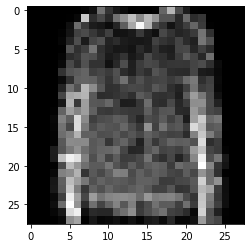

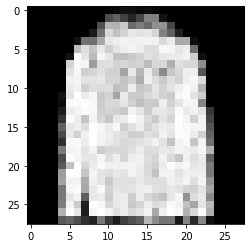

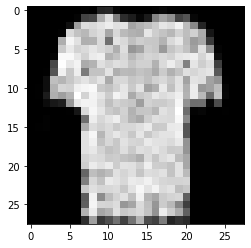

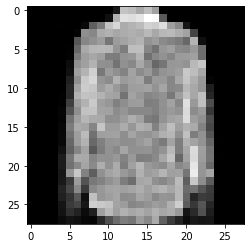

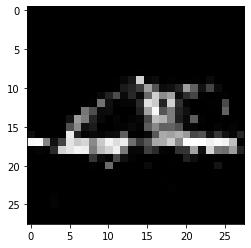

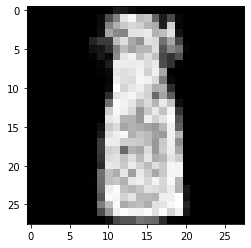

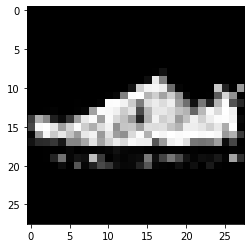

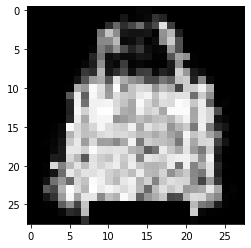

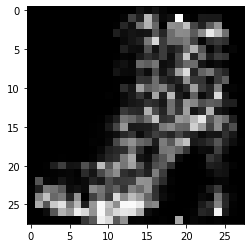

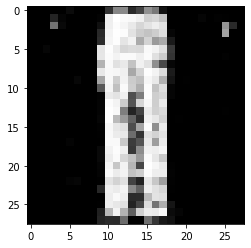

In [13]:
# 생성자가 만든 이미지 시각화하기
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()